In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from pathlib import Path
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np
import re

## Do preprocessing

In [3]:
raw_dir = Path("/micehome/nwang/repos/datastory/fastai/Cnp-GFP_D-R/raw")
raws = raw_dir.ls()

processed_dir = Path("/micehome/nwang/repos/datastory/fastai/Cnp-GFP_D-R/processed")
l=224

In [4]:
img = cv2.imread(raws[2].as_posix(), cv2.COLOR_BGR2GRAY)

In [5]:
if False:
    for raw_path in raws:
        img = cv2.imread(raw_path.as_posix(), cv2.COLOR_BGR2GRAY)
        
        if "_label" in raw_path.as_posix():
            img[img!=0]=1

        i_max = img.shape[0]//l
        j_max = img.shape[1]//l

        for i in range(i_max):
            for j in range(j_max):
                save_path = processed_dir/(raw_path.stem + "_i" + str(i) + "_j" + str(j) + raw_path.suffix)
#                 print(save_path)
                cv2.imwrite(save_path.as_posix(), img[l*i:l*(i+1), l*j:l*(j+1)])

In [6]:
# for path in processed_dir.ls():
#     if "_label_" in path.as_posix():
#         print(np.unique(cv2.imread(path.as_posix(), cv2.COLOR_BGR2GRAY)))

## Train NN

In [7]:
codes = ["CELL", "NOT-CELL"]
bs = 8

In [17]:
transforms = get_transforms(
    do_flip = True,
    flip_vert = True,
    max_zoom = 1, #consider
    max_rotate=10.0,
    max_lighting=0.1,
    max_warp = None,
    p_affine = 0.75,
    p_lighting = 0.75)

In [18]:
get_label_from_image = lambda path: re.sub(r'_image_', '_label_', path.as_posix())

src = (
    SegmentationItemList.from_folder(processed_dir)
    .filter_by_func(lambda fname: 'image' in Path(fname).name)
    .split_by_rand_pct(valid_pct=0.2, seed=1)
    .label_from_func(get_label_from_image, classes=codes)
)
data = (
    src.transform(transforms)
    .databunch(bs=bs)
    .normalize(imagenet_stats)
)

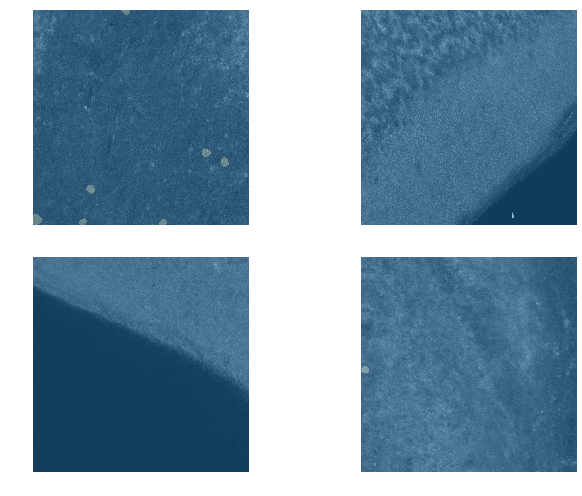

In [19]:
data.show_batch(2, figsize=(10,7))

In [21]:
wd=1e-2

In [22]:
learn = unet_learner(data, models.resnet34, metrics=dice, wd=wd)
learn.loss_func = CrossEntropyFlat(axis=1, weight = torch.Tensor([0.2,1]).cuda())

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


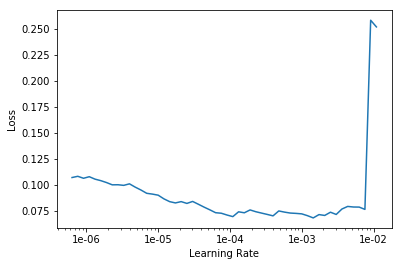

In [23]:
lr_find(learn)
learn.recorder.plot()

In [24]:
lr=2e-5

In [25]:
learn.fit_one_cycle(30, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,dice,time
0,0.062610,0.065756,0.000115,00:43
1,0.051103,0.062907,0.000000,00:42
2,0.045904,0.058186,0.000000,00:42


KeyboardInterrupt: 

In [ ]:
learn.save('stage-1')

In [ ]:
learn.load('stage-1');

In [ ]:
learn.show_results(rows=4)

In [ ]:
learn.show_results(rows=7, ds_type=DatasetType.Train)

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(lr/400,lr/4)

In [ ]:
learn.fit_one_cycle(15, lrs, pct_start=0.8)

In [ ]:
learn.save('stage-2');

In [ ]:
learn.show_results(rows=6, ds_type=DatasetType.Train)